In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd '/content/drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [3]:
import numpy as np
from numpy.random import choice
import pandas as pd
from scipy.io import loadmat
import keras
from sklearn.model_selection import train_test_split
from math import floor
import random
import copy
import json

Using TensorFlow backend.


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, MaxPooling1D, Conv1D, Dropout
from keras import regularizers, optimizers
from keras.constraints import maxnorm
from keras import backend as tf

In [0]:
#encode sequence into tensor
def encode(df):
  n = df.shape[0]
  m = df['sequence'].map(len).max()
  a = np.empty((n,m,4))
  
  d = {'A': np.array([1,0,0,0]),
       'C': np.array([0,1,0,0]),
       'G': np.array([0,0,1,0]),
       'T': np.array([0,0,0,1]), 
       'N': np.array([0,0,0,0])}

  for i in range(n):
    seq = df['sequence'][i]
    extra = m-len(seq)
    if extra > 0:
      seq += 'N'*extra
    
    seq_array = list(seq)
    for j in range(m):
      base = seq_array[j]
      a[i][j] = d[base]
    
  return a

In [0]:
pos = pd.read_csv('all_rbp_sequences.csv')
neg = pd.read_csv('all_neg_seqs.csv')

#MULTIPLE RBPs

In [0]:
df_5 = pos[pos['RBP'] == 'K562.RPS5'].reset_index()
df_11 = pos[pos['RBP'] == 'K562.RPS11'].reset_index()

In [0]:
overlap = []
for index, row in df_5.iterrows():
  start = row.start
  end = row.end
  df_temp = df_11[(df_11['chromosome'] == row.chromosome) & (df_11['strand'] == row.strand)]
  for i,j in df_temp.iterrows():    
    #try to add their start after your end
    #change to binary search
    if (j.start > start and j.start < end) or (j.end > start and j.end < end):
      overlap.append((index,i))
      break

In [62]:
df_5.shape

(13046, 7)

In [63]:
df_11.shape

(3074, 7)

In [64]:
len(overlap)

1898

In [0]:
df_pos = pd.concat([df_5, df_11],ignore_index=True)

In [0]:
df_pos.tail()

,index,RBP,chromosome,start,end,strand,sequence
16115,5162363,K562.RPS11,X,77373579,77373687,+,GCTGGTGGGTTTTTGATGAAGAAGGAGCTGAACTACTTTGCAAAGG...
16116,5162364,K562.RPS11,X,77378752,77378854,+,GCTGAGAAGAATGGTGTGAAGATTACCTTGCCTGTTGACTTTGTCA...
16117,5162365,K562.RPS11,11,66394430,66394534,+,CCTGGCTCCCTTTTATTTTTGTGCGCGATATTTAAGGTCGTCTGGA...
16118,5162366,K562.RPS11,22,38270406,38270516,+,GGGCGGCACTCCCTCTACAAAATGCTTGGTTACTTCAGCCTGGTCG...
16119,5162367,K562.RPS11,9,35470998,35471119,+,TTTTCTGCTTTCTCCTTAGTGTTGAAATAATAAGATTGGGCAACAG...


In [0]:
a_pos = encode(df_pos)

In [0]:
df_neg = neg[(neg['RBP'] == 'K562.RPS5') | (neg['RBP'] == 'K562.RPS11')].reset_index()
a_neg = encode(df_neg)

In [0]:
#combine pos and neg seqs
seqs = np.concatenate((a_pos, a_neg), axis=0)

In [0]:
n = df_5.shape[0] + df_11.shape[0]
pos_labels = np.zeros((n,2))

In [0]:
overlap_5 = []
overlap_11 = []
for tup in overlap:
  overlap_5.append(tup[0])
  overlap_11.append(tup[1])

In [0]:
overlap_5 = set(overlap_5)
overlap_11 = set(overlap_11)

In [0]:
for i in range(n):
  if i < df_5.shape[0]:
    pos_labels[i][0] = 1
    if i in overlap_5:
      pos_labels[i][1] = 1
  else:
    pos_labels[i][1] = 1
    if i in overlap_11:
      pos_labels[i][0] = 1

In [0]:
neg_labels = np.zeros((df_neg.shape[0],2))

#combine pos and neg labels
labels = np.concatenate((pos_labels, neg_labels), axis=0)

In [74]:
labels.shape

(32240, 2)

In [75]:
seqs.shape

(32240, 146, 4)

In [0]:
#split into train and test data
(trainX, testX, trainY, testY) = train_test_split(seqs, labels, test_size=0.2, random_state=7)

#create validation set
(trainX, validX, trainY, validY) = train_test_split(trainX, trainY, test_size=0.1, random_state=15)

In [0]:
#initialize net
model = Sequential()

#conv layer
model.add(Conv1D(320, kernel_size=8, activation='relu', input_shape=(146,4), 
                 kernel_regularizer=regularizers.l2(.01)))

#pooling layer
model.add(MaxPooling1D(pool_size=4, strides=None, padding='valid'))
model.add(Dropout(.2))

#conv layer
model.add(Conv1D(480, kernel_size=8, activation='relu',
                 kernel_regularizer=regularizers.l2(.01)))

#pooling layer
model.add(MaxPooling1D(pool_size=4, strides=None, padding='valid'))
model.add(Dropout(.2))

#fully connected layer
model.add(Flatten())
model.add(Dense(925, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.2))

#sigmoid layer
model.add(Dense(2, activation="sigmoid"))

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [79]:
#train model
model.fit(trainX, trainY,
          batch_size=16,
          epochs=7,
          verbose=1,
          validation_data=(validX, validY))

Train on 23212 samples, validate on 2580 samples
Epoch 1/7
23212/23212 [==============================] - 236s 10ms/step - loss: 3.3120 - acc: 0.8986 - val_loss: 2.5403 - val_acc: 0.8957
Epoch 2/7
23212/23212 [==============================] - 232s 10ms/step - loss: 1.9956 - acc: 0.9050 - val_loss: 1.5728 - val_acc: 0.8957
Epoch 3/7
23212/23212 [==============================] - 235s 10ms/step - loss: 1.2578 - acc: 0.9050 - val_loss: 1.0259 - val_acc: 0.8957
Epoch 4/7
23212/23212 [==============================] - 231s 10ms/step - loss: 0.8440 - acc: 0.9050 - val_loss: 0.7196 - val_acc: 0.8957
Epoch 5/7
23212/23212 [==============================] - 236s 10ms/step - loss: 0.6120 - acc: 0.9050 - val_loss: 0.5538 - val_acc: 0.8957
Epoch 6/7
23212/23212 [==============================] - 238s 10ms/step - loss: 0.4821 - acc: 0.9050 - val_loss: 0.4522 - val_acc: 0.8957
Epoch 7/7
23212/23212 [==============================] - 238s 10ms/step - loss: 0.4097 - acc: 0.9050 - val_loss: 0.3988 - v

In [0]:
model.save('multi_part2.h5')

In [0]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(testX)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(testY[:,0], y_pred_keras[:,0])

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [81]:
auc_keras

0.6846073410501053

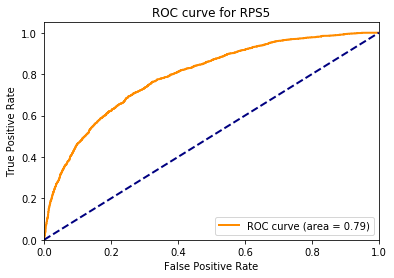

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

plt.figure()
lw = 2
plt.plot(fpr_keras, tpr_keras, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for RPS5')
plt.legend(loc="lower right")
plt.show()


In [0]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(testX)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(testY[:,1], y_pred_keras[:,1])

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [83]:
auc_keras

0.580577801354522

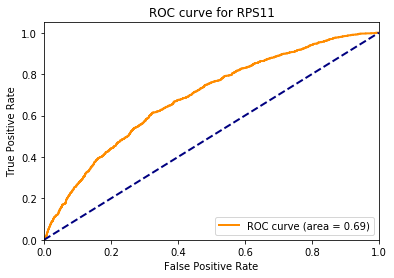

In [31]:
plt.figure()
lw = 2
plt.plot(fpr_keras, tpr_keras, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for RPS11')
plt.legend(loc="lower right")
plt.show()

#SINGLE RBP

In [0]:
#isolate RBFOX2 into a df
df_pos = pos[pos['RBP'] == 'K562.RPS11'].reset_index()
#df_pos = pos[pos['RBP'] == 'HepG2.TBRG4'].reset_index()
a_pos = encode(df_pos)

#read in negative sequences
df_neg = neg[neg['RBP'] == 'K562.RPS11'].reset_index()
#df_neg = neg[neg['RBP'] == 'HepG2.TBRG4'].reset_index()
a_neg = encode(df_neg)

In [0]:
#combine pos and neg seqs
seqs = np.concatenate((a_pos, a_neg), axis=0)

#combine pos and neg labels
pos_labels, neg_labels = np.ones((a_pos.shape[0])), np.zeros((a_neg.shape[0]))
labels = np.concatenate((pos_labels, neg_labels), axis=0)

In [0]:
#split into train and test data
(trainX, testX, trainY, testY) = train_test_split(seqs, labels, test_size=0.2, random_state=7)

#create validation set
(trainX, validX, trainY, validY) = train_test_split(trainX, trainY, test_size=0.1, random_state=15)

In [0]:
#initialize net
model = Sequential()

#conv layer
model.add(Conv1D(320, kernel_size=8, activation='relu', input_shape=(146,4), 
                 kernel_regularizer=regularizers.l2(.01)))

#pooling layer
model.add(MaxPooling1D(pool_size=4, strides=None, padding='valid'))
model.add(Dropout(.2))

#conv layer
model.add(Conv1D(480, kernel_size=8, activation='relu',
                 kernel_regularizer=regularizers.l2(.01)))

#pooling layer
model.add(MaxPooling1D(pool_size=4, strides=None, padding='valid'))
model.add(Dropout(.2))

#fully connected layer
model.add(Flatten())
model.add(Dense(925, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.2))

#sigmoid layer
model.add(Dense(1, activation="sigmoid"))

In [0]:
#sum of negative log likelihood
def obj_loss(y_true, y_pred):
    return tf.sum(tf.binary_crossentropy(y_true, y_pred), axis=-1)

In [0]:
model.compile(loss=obj_loss,
              optimizer='sgd',
              metrics=['accuracy'])

In [59]:
#train model
model.fit(trainX, trainY,
          batch_size=16,
          epochs=10,
          verbose=1,
          validation_data=(validX, validY))

Train on 4426 samples, validate on 492 samples
Epoch 1/10
4426/4426 [==============================] - 43s 10ms/step - loss: 0.4982 - acc: 0.7512 - val_loss: 0.4696 - val_acc: 0.7866
Epoch 2/10
4426/4426 [==============================] - 42s 10ms/step - loss: 0.4033 - acc: 0.8138 - val_loss: 0.4792 - val_acc: 0.8049
Epoch 3/10
4426/4426 [==============================] - 43s 10ms/step - loss: 0.3010 - acc: 0.8696 - val_loss: 0.5144 - val_acc: 0.7846
Epoch 4/10
4426/4426 [==============================] - 42s 10ms/step - loss: 0.2121 - acc: 0.9164 - val_loss: 0.5049 - val_acc: 0.7927
Epoch 5/10
4426/4426 [==============================] - 43s 10ms/step - loss: 0.1532 - acc: 0.9358 - val_loss: 0.7185 - val_acc: 0.7744
Epoch 6/10
4426/4426 [==============================] - 43s 10ms/step - loss: 0.1214 - acc: 0.9557 - val_loss: 0.7347 - val_acc: 0.7703
Epoch 7/10
4426/4426 [==============================] - 43s 10ms/step - loss: 0.1059 - acc: 0.9620 - val_loss: 0.7043 - val_acc: 0.7825
E

In [0]:
model.save('3dense_part2.h5')

In [0]:
from keras.models import load_model
model = load_model('3dense.h5',custom_objects={'obj_loss': obj_loss})

In [0]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(testX).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(testY, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [61]:
auc_keras

0.8824033368644066

In [0]:
 from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from matplotlib import pyplot

precision, recall, thresholds = precision_recall_curve(testY, y_pred_keras)

In [0]:
yhat = model.predict_classes(testX)

f1=0.858 auc=0.927 ap=0.927


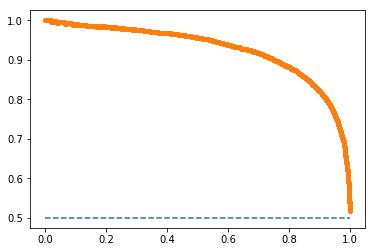

In [0]:
# calculate F1 score
f1 = f1_score(testY, yhat)
# calculate precision-recall AUC
auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(testY, y_pred_keras)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
pyplot.show()

In [0]:
#PLOT PREDICTION SCORE DISTRIBUTION
valprob = model.predict(validX)

In [0]:
pos_set, neg_set = [], []
for i in range(len(validY)):
  if validY[i] == 1:
    pos_set.append(valprob[i][0])
  else:
    neg_set.append(valprob[i][0])

(array([2385.,  660.,  424.,  337.,  266.,  196.,  216.,  195.,  164.,
          92.]),
 array([0.        , 0.09942126, 0.19884253, 0.2982638 , 0.39768505,
        0.4971063 , 0.5965276 , 0.69594884, 0.7953701 , 0.89479136,
        0.9942126 ], dtype=float32),
 <a list of 10 Patch objects>)

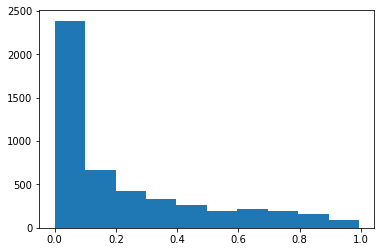

In [0]:
import matplotlib.pyplot as plt
plt.hist(neg_set)

(array([  56.,   84.,  104.,  132.,  169.,  231.,  353.,  548.,  916.,
        2150.]),
 array([0.00436363, 0.10392037, 0.20347711, 0.30303386, 0.4025906 ,
        0.5021473 , 0.60170406, 0.7012608 , 0.80081755, 0.9003743 ,
        0.99993104], dtype=float32),
 <a list of 10 Patch objects>)

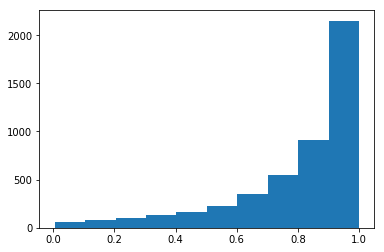

In [0]:
plt.hist(pos_set)

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [0]:
sns.set(color_codes=True)

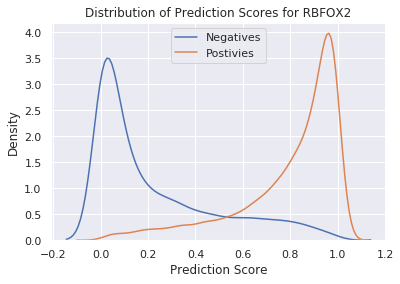

In [0]:
ax = sns.distplot(neg_set, hist=False, label='Negatives')
ax = sns.distplot(pos_set, hist=False, label='Postivies')
ax.set(xlabel='Prediction Score', ylabel='Density')
ax.set_title('Distribution of Prediction Scores for RBFOX2')

plt.show()

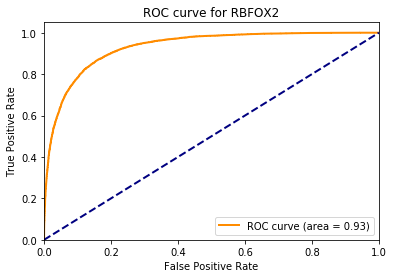

In [0]:
import numpy as np

from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

plt.figure()
lw = 2
plt.plot(fpr_keras, tpr_keras, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for RBFOX2')
plt.legend(loc="lower right")
plt.show()
